In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import resnet18
from tqdm import tqdm

from fewshot_sampler import FewShotSampler
from fewshot_utils import plot_images, sliding_average

In [10]:
from pathlib import Path
from wrap_few_shot_dataset import WrapFewShotDataset

image_size = 28

# Setup path to data folder
data_path = Path("data")
image_path = data_path / "UCMerced-Fewshot"

# Check if image folder exists
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory")
    exit()

# Setup train and testing paths
train_dir = image_path / "Train"
test_dir = image_path / "Test"

# Write transform for image
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])


train_set = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform,
)

test_set = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform,
)

train_set = WrapFewShotDataset(train_set)
test_set = WrapFewShotDataset(test_set)

data/UCMerced-Fewshot directory exists.


Scrolling dataset's labels...: 100%|██████████| 900/900 [00:00<00:00, 1032.11it/s]


In [11]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

test_sampler = FewShotSampler (
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=8,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).
Now, as every data scientist should do before launching opaque training scripts,
let's take a look at our dataset.

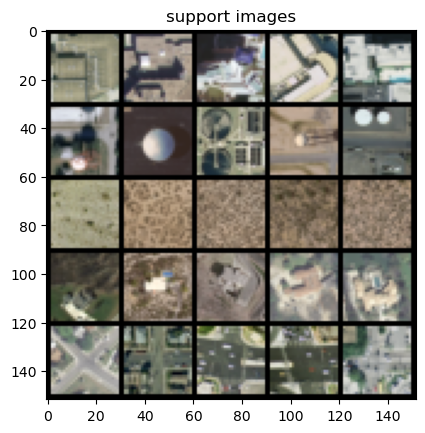

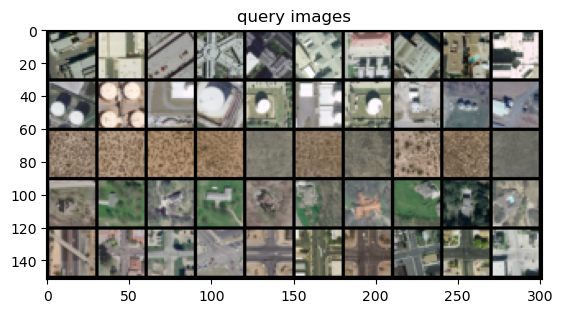

In [13]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

For both support and query set, you should have one line for each class.

How does our model perform on this task?

This doesn't look bad: keep in mind that the model was trained on very different images, and has only seen 5 examples for each class!

Now that we have a first idea, let's see more precisely how good our model is.

In [14]:
model.eval()

def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images, support_labels, query_images)
            .detach()
            .data,
            1,
        )[1]
        == query_labels
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(data_loader, total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]

Model tested on 100 tasks. Accuracy: 59.82%


With absolutely zero training on Omniglot images, and only 5 examples per class, we achieve around 86% accuracy! Isn't this a great start?

Now that you know how to make Prototypical Networks work, you can see what happens if you tweak it
a little bit (change the backbone, use other distances than euclidean...) or if you change the problem
(more classes in each task, less or more examples in the support set, maybe even one example only,
but keep in mind that in that case Prototypical Networks are just standard nearest neighbour).

When you're done, you can scroll further down and learn how to **meta-train this model**, to get even better results.

## Training a meta-learning algorithm

Let's use the "background" images of Omniglot as training set. Here we prepare a data loader of 40 000 few-shot classification
tasks on which we will train our model. The alphabets used in the training set are entirely separated from those used in the testing set.
This guarantees that at test time, the model will have to classify characters that were not seen during training.

Note that we don't set a validation set here to keep this notebook concise,
but keep in mind that **this is not good practice** and you should always use validation when training a model for production.

In [15]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_sampler = FewShotSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=8,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

We will keep the same model. So our weights will be pre-trained on ImageNet. If you want to start a training from scratch,
feel free to set `pretrained=False` in the definition of the ResNet.

Here we define our loss and our optimizer (cross entropy and Adam, pretty standard), and a `fit` method.
This method takes a classification task as input (support set and query set). It predicts the labels of the query set
based on the information from the support set; then it compares the predicted labels to ground truth query labels,
and this gives us a loss value. Then it uses this loss to update the parameters of the model. This is a *meta-training loop*.

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images, support_labels, query_images
    )

    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks,
and let the `fit` method update our model after each task. This is called **episodic training**.

This took me 20mn on an RTX 2080 and I promised you that this whole tutorial would take 15mn.
So if you don't want to run the training yourself, you can just skip the training and load the model that I trained
using the exact same code.

In [17]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  0%|          | 15/40000 [00:13<9:44:00,  1.14it/s, loss=1.32]


KeyboardInterrupt: 

In [ ]:
# Or just load mine

!wget https://public-sicara.s3.eu-central-1.amazonaws.com/easy-fsl/resnet18_with_pretraining.tar
model.load_state_dict(torch.load("resnet18_with_pretraining.tar", map_location="cuda"))

Now let's see if our model got better!

In [ ]:
evaluate(test_loader)

100%|██████████| 100/100 [00:03<00:00, 30.45it/s]

Model tested on 100 tasks. Accuracy: 98.08%


Around 98%!

It's not surprising that the model performs better after being further trained on Omniglot images than it was with its
ImageNet-based parameters. However, we have to keep in mind that the classes on which we just evaluated our model were still
**not seen during training**, so 99% (with a 12% improvement over the model trained on ImageNet) seems like a decent performance.

## What have we learned?

- What a Prototypical Network is and how to implement one in 15 lines of code.
- How to use Omniglot to evaluate few-shot models
- How to use custom PyTorch objets to sample batches in the shape of a few-shot classification tasks.
- How to use meta-learning to train a few-shot algorithm.

## What's next?

- Take this notebook in your own hands, tweak everything that there is to tweak. It's the best way to understand what does what.
- Implement other few-shot learning methods, such as Matching Networks, Relation Networks, MAML...
- Try other ways of training. Episodic training is not the only way to train a model to generalize to new classes!
- Experiment on other, more challenging few-shot learning benchmarks, such as [CUB](http://www.vision.caltech.edu/visipedia/CUB-200.html)
or [Meta-Dataset](https://github.com/google-research/meta-dataset).
- If you liked this tutorial, feel free to ⭐ [give us a star on Github](https://github.com/sicara/easy-few-shot-learning) ⭐
- **Contribute!** The companion repository of this notebook is meant to become a boilerplate, a source of useful code that
that newcomers can use to start their few-shot learning projects.
